In [1]:
import numpy as np

import cellrank as cr
import scanpy as sc
import scvelo as scv

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import anndata as ad
from scipy import io,sparse
import os

In [3]:
def starsolo_velocity_anndata(input_dir):
    """
    input directory should contain barcodes.tsv, features.tsv with 3 mtx from spliced, ambigious, unspliced
    """
    obs = pd.read_csv(os.path.join(input_dir,'barcodes.tsv'), header = None, index_col = 0)
    # Remove index column name to make it compliant with the anndata format
    obs.index.name = None

    var = pd.read_csv(os.path.join(input_dir,"features.tsv"), sep='\t',names = ('gene_ids', 'feature_types'), index_col = 1)
    var.index.name = None

    spliced=sci.sparse.csr_matrix(sci.io.mmread(os.path.join(input_dir,"spliced.mtx")).T)
    ambiguous=sci.sparse.csr_matrix(sci.io.mmread(os.path.join(input_dir,"ambiguous.mtx")).T)
    unspliced=sci.sparse.csr_matrix(sci.io.mmread(os.path.join(input_dir,"unspliced.mtx")).T)
    adata=ad.AnnData(X=spliced,obs=obs,var=var,layers={'spliced':spliced,"ambiguous":ambiguous,"unspliced":unspliced})
    adata.var_names_make_unique()
    return adata

In [4]:
adata = starsolo_velocity_anndata('/mnt/LaCIE/annaM/gut_project/raw_data/Elmentaite_2021/remapped_fetal_data_E-MTAB-9536_starsolo/FCA_gut8015057/FCA_gut8015057/Velocyto/raw')

In [5]:
transcripts_to_genes = pd.read_csv('/mnt/LaCIE/annaM/human_reference_genome/index_file_bustool/transcripts_to_genes.txt', sep='\t')
transcripts_to_genes.head()
transcripts_to_genes.loc[-1] = transcripts_to_genes.columns
transcripts_to_genes.rename(columns={'TCONS_00023547':'transcript_id', 'XLOC_006889':'locus_id', 'DDX11L1':'gene_id', 'chr1':'chromosome', '11869':'start_position', '14409':'end_position'}, inplace=True)

In [6]:
adata.var.index.name = 'locus_id'

# Check uniqueness in transcripts_to_genes
if not transcripts_to_genes['locus_id'].is_unique:
    # Handle duplicates here. For example, you might want to aggregate or drop duplicates.
    transcripts_to_genes = transcripts_to_genes.drop_duplicates(subset='locus_id')

# Merge operation (with 'locus_id' now as a column in adata.var)
merged_data = pd.merge(adata.var.reset_index(), transcripts_to_genes, on='locus_id', how='left')

# Check if the merge did not introduce extra rows
if merged_data.shape[0] == adata.var.shape[0]:
    adata.var = merged_data.set_index('locus_id')
else:
    print("Merge operation introduced extra rows, please check your data.")


# copy index column to a new column called locus_id
adata.var['locus_id'] = adata.var.index

# make gene_id as index
adata.var.set_index('gene_id', inplace=True)

adata.var = adata.var.astype(str)

+ Run CellRank

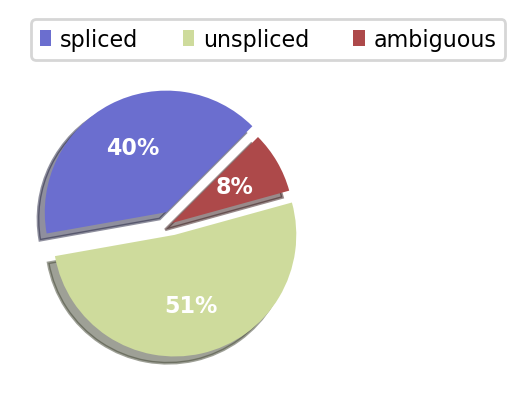

AnnData object with n_obs × n_vars = 737280 × 65079
    var: 'gene_ids', 'feature_types', 'transcript_id', 'Unnamed: 3', 'chromosome', 'start_position', 'end_position', '+', 'locus_id'
    layers: 'spliced', 'ambiguous', 'unspliced'

In [7]:
scv.pl.proportions(adata)
adata

In [8]:
scv.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=False
)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

/home/amaguza/miniforge3/envs/CellRank_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/amaguza/miniforge3/envs/CellRank_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/amaguza/miniforge3/envs/CellRank_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/amaguza/miniforge3/envs/CellRank_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/amaguza/miniforge3/envs/CellRank_env/lib/python3.1

Filtered out 64615 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.
Normalized count data: X, spliced, unspliced.
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [9]:
scv.tl.recover_dynamics(adata, n_jobs=8)

recovering dynamics (using 8/64 cores)
    finished (0:03:22) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)

outputs model fit of gene: ENSG00000262413


In [12]:
scv.tl.velocity(adata, mode="dynamical")

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [13]:
vk = cr.kernels.VelocityKernel(adata)

In [14]:
vk.compute_transition_matrix()

Computing transition matrix using `'deterministic'` model


100%|██████████████████████████████████████████████████████| 737280/737280 [01:14<00:00, 9937.19cell/s]


Using `softmax_scale=nan`


100%|█████████████████████████████████████████████████████| 737280/737280 [00:58<00:00, 12651.44cell/s]


    Finish (0:02:13)


VelocityKernel[n=737280, model='deterministic', similarity='correlation', softmax_scale=nan]

In [15]:
vk = cr.kernels.VelocityKernel(adata)

In [16]:
vk.compute_transition_matrix()

Computing transition matrix using `'deterministic'` model


100%|█████████████████████████████████████████████████████| 737280/737280 [00:57<00:00, 12813.14cell/s]


Using `softmax_scale=nan`


100%|█████████████████████████████████████████████████████| 737280/737280 [00:58<00:00, 12566.61cell/s]


    Finish (0:01:57)


VelocityKernel[n=737280, model='deterministic', similarity='correlation', softmax_scale=nan]

In [17]:
ck = cr.kernels.ConnectivityKernel(adata)
ck.compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


In [18]:
print(combined_kernel)

(0.8 * VelocityKernel[n=737280] + 0.2 * ConnectivityKernel[n=737280])


In [19]:
vk.plot_projection()

Projecting transition matrix onto `umap`


KeyError: "Unable to find a basis in `adata.obsm['X_umap']` or `adata.obsm['umap']`."

In [ ]:
vk.plot_random_walks(start_ixs={"clusters": "Ngn3 low EP"}, max_iter=200, seed=0)